Installing dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
import string
import random
import logging
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow import random
tf.random.set_seed(1)

<ipython-input-2-37706e97b866>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


Pre-processing data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/FND_Kannada/data/v2/train.csv')
df_train.head()

,news,source,label
0,ಈ ವ್ಯಕ್ತಿ ಪ್ರೌಢಶಾಲೆಯಲ್ಲಿ 26 ಬಾರಿ ಫೇಲ್ ಆಗಿದ್ದಾನೆ,oneindia,0
1,ಸರ್ಕಾರದ ಜೊತೆ ಉದ್ಧವ್ ಠಾಕ್ರೆಯ ಪಕ್ಷವನ್ನೂ ವಶಪಡಿಸ್ಕ...,asianet,1
2,ಹುಲಿ ಸಂರಕ್ಷಿತ ಪ್ರದೇಶ ಘೋಷಣೆ ಸಿಎಂ ನಿರ್ಧಾರಕ್ಕೆ ಉಮ...,prajavani,1
3,108 ಗಂಟೆಯಲ್ಲಿ 75 ಕಿಮೀ ರಸ್ತೆ ನಿರ್ಮಾಣದ ಗುರಿ ಗಿನ್...,asianet,1
4,ಬಾಳಾಠಾಕ್ರೆ ತಿಲಕ ಇಡುತ್ತಿರುವುದು ಏಕನಾಥ್ ಶಿಂಧೆಗಲ್...,asianet,0


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/FND_Kannada/data/v2/test.csv')
df_test.head()

,news,source,label
0,ನಿರಂತರ ಮಳೆ: ಕೊಳೆತ ಉದ್ದು ಬೆಳೆ ...,prajavani,1
1,ಸಲಿಂಗ ಸಂಬಂಧ ವಿರೋಧಿಸಿದ್ದಕ್ಕೆ ಲಿಂಗ ಬದಲಿಸಿಕೊಂಡಳು,asianet,1
2,ನ್ಯೂಯಾರ್ಕ್ ಟೈಮ್ಸ್‌ ಮುಖಪುಟದಲ್ಲಿ ಮೋದಿ ಬಗ್ಗೆ ವರದ...,oneindia,0
3,ಡ್ರೋಣ್ ಬಾಯ್ ಪ್ರತಾಪ್‌ನನ್ನು ವಿಜ್ಞಾನಿಯಾಗಿ DRDOಗೆ ...,factly,0
4,"ಎಸ್ಎಂಕೆ, ನಾರಾಯಣ ಮೂರ್ತಿ, ಪ್ರಕಾಶ್ ಪಡುಕೋಣೆಗೆ ಕೆಂಪ...",asianet,1


In [ ]:
y_train = to_categorical(df_train.label.values)
y_test = to_categorical(df_test.label.values)

In [ ]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
df_train.dtypes

news      object
source    object
label      int64
dtype: object

In [ ]:
maxi = -1
for i, rev in enumerate(df_train['news']):
    rev = str(rev)
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)
print(maxi)

20


In [ ]:
df_train['news'] = df_train.news.astype(str)
df_test['news'] = df_test.news.astype(str)

In [ ]:
#tokenizing the text
tf.random.set_seed(1)
tokenizer = Tokenizer()
df_total = pd.concat([df_train['news']], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
max_rev_len = maxi
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 300

In [ ]:
print(len(tokenizer.word_index))

9162


In [ ]:
#padding the tokenized text
tf.random.set_seed(1)
X_train = tokenizer.texts_to_sequences(df_train['news'])  
X_train_pad = pad_sequences(X_train, maxlen = max_rev_len, padding = 'post')  
X_test = tokenizer.texts_to_sequences(df_test.news)
X_test_pad = pad_sequences(X_test, maxlen = max_rev_len, padding = 'post')

Training the data on the model

In [ ]:
#defining the layers in the model
tf.random.set_seed(1)
def create_model():
  class_num = 2
  model = Sequential()
  model.add(Embedding(input_dim = vocab_size, output_dim = 300, input_length = max_rev_len, trainable = True))
  model.add(Bidirectional(LSTM(128, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.5)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(64, return_sequences = False, dropout = 0.2, recurrent_dropout = 0.5)))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(class_num, activation = 'softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')
  return model

In [ ]:
tf.random.set_seed(1)
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 300)           2748900   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 256)          439296    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 20, 256)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
#saving weights of the best model
tf.random.set_seed(1)
checkpoint_filepath = '/content/drive/MyDrive/FND_Kannada/data/v2/Checkpoints/lstm.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1,
    save_best_only = True)

In [ ]:
X_train_pad.shape

(2300, 20)

In [ ]:
y_train.shape

(2300, 2)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [ ]:
tf.random.set_seed(1)
history_embedding = model.fit(X_train_pad, y_train, epochs = 100, callbacks = [model_checkpoint_callback, early_stopping_callback], batch_size = 64, validation_split = 0.1, verbose = 1)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.6396
Epoch 1: val_accuracy improved from -inf to 0.65217, saving model to /content/drive/MyDrive/FND_Kannada/data/v2/Checkpoints/lstm.hdf5
33/33 [==============================] - 20s 354ms/step - loss: 0.6567 - accuracy: 0.6396 - val_loss: 0.6332 - val_accuracy: 0.6522
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.5213 - accuracy: 0.7696
Epoch 2: val_accuracy improved from 0.65217 to 0.81739, saving model to /content/drive/MyDrive/FND_Kannada/data/v2/Checkpoints/lstm.hdf5
33/33 [==============================] - 13s 401ms/step - loss: 0.5213 - accuracy: 0.7696 - val_loss: 0.5081 - val_accuracy: 0.8174
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9691
Epoch 3: val_accuracy improved from 0.81739 to 0.83913, saving model to /content/drive/MyDrive/FND_Kannada/data/v2/Checkpoints/lstm.hdf5
33/33 [==============================] - 12

Visualizing the training and validation results

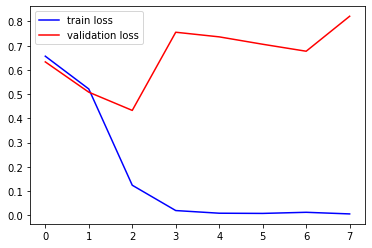

In [ ]:
plt.plot(history_embedding.history['loss'], c = 'b', label = 'train loss')
plt.plot(history_embedding.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

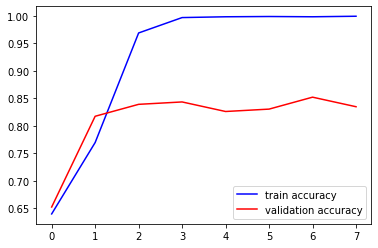

In [ ]:
plt.plot(history_embedding.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history_embedding.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc='lower right')
plt.show()

Extracting classification report and confusion matrix

In [ ]:
tf.random.set_seed(1)

In [ ]:
y_pred = np.argmax(model.predict(X_test_pad), axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred))

16/16 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       200
           1       0.85      0.82      0.84       300

    accuracy                           0.81       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.81      0.81      0.81       500



In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[157  43]
 [ 53 247]]


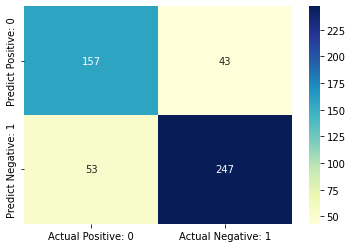

In [ ]:
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive: 0', 'Actual Negative: 1'], index = ['Predict Positive: 0', 'Predict Negative: 1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')

Extracting csv file representing actual and predicted values

In [ ]:
labels = []
for i in range(len(y_test)):
     if y_pred[i] != y_true[i]:
         if y_pred[i] == 0:
             labels.append("False Positive")
         if y_pred[i] == 1:
             labels.append("False Negative")
     if y_pred[i] == y_true[i]:
         if y_pred[i] == 0:
             labels.append("True Positive")
         if y_pred[i] == 1:
             labels.append("True Negative")

In [ ]:
output_data = df_test.copy()
output_data['Predictions'] = y_pred
output_data['Remarks'] = labels
output_data.head()

,news,source,label,Predictions,Remarks
0,ನಿರಂತರ ಮಳೆ: ಕೊಳೆತ ಉದ್ದು ಬೆಳೆ ...,prajavani,1,1,True Negative
1,ಸಲಿಂಗ ಸಂಬಂಧ ವಿರೋಧಿಸಿದ್ದಕ್ಕೆ ಲಿಂಗ ಬದಲಿಸಿಕೊಂಡಳು,asianet,1,1,True Negative
2,ನ್ಯೂಯಾರ್ಕ್ ಟೈಮ್ಸ್‌ ಮುಖಪುಟದಲ್ಲಿ ಮೋದಿ ಬಗ್ಗೆ ವರದ...,oneindia,0,0,True Positive
3,ಡ್ರೋಣ್ ಬಾಯ್ ಪ್ರತಾಪ್‌ನನ್ನು ವಿಜ್ಞಾನಿಯಾಗಿ DRDOಗೆ ...,factly,0,0,True Positive
4,"ಎಸ್ಎಂಕೆ, ನಾರಾಯಣ ಮೂರ್ತಿ, ಪ್ರಕಾಶ್ ಪಡುಕೋಣೆಗೆ ಕೆಂಪ...",asianet,1,1,True Negative


In [ ]:
output_data.to_csv('/content/drive/MyDrive/FND_Kannada/data/v2/Predictions/lstm.csv', index = False) 

Loadiing the saved model

In [ ]:
tf.random.set_seed(1)

In [ ]:
model2 = create_model()
model2.load_weights('/content/drive/MyDrive/FND_Kannada/data/v2/Checkpoints/lstm.hdf5')

In [ ]:
tf.random.set_seed(1)

In [ ]:
y_pred = np.argmax(model2.predict(X_test_pad), axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred))

16/16 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       200
           1       0.85      0.83      0.84       300

    accuracy                           0.81       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.81      0.81      0.81       500



In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[156  44]
 [ 51 249]]


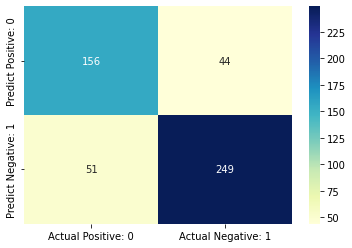

In [ ]:
cm_matrix = pd.DataFrame(data = cm, columns = ['Actual Positive: 0', 'Actual Negative: 1'], index = ['Predict Positive: 0', 'Predict Negative: 1'])
sns.heatmap(cm_matrix, annot = True, fmt = 'd', cmap = 'YlGnBu')